In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
import torch
from src.data.loaders import MitoSemsegDataset
from src.analysis.components import crop_all_mitos
import ipywidgets as widgets

dataset = MitoSemsegDataset(root=TRAIN_ROOT, indices=[81])
img, mask = dataset[0]

/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [ ]:
from functools import partial
from src.analysis.components import bottomhat, close_rc, area_filter, prune, close, holefill, contour_smoothing, open_rc

@widgets.interact(sesize=(1,100,1),ksize=(1,100,1),type=[('cross',cv.MORPH_CROSS),('disc',cv.MORPH_ELLIPSE),('rect',cv.MORPH_RECT)],low=(0,255),up=(0,255),thres=(0,500),p=(0.01,1.,0.01))
def plot(sesize=25, ksize=12, type=cv.MORPH_ELLIPSE,low=0,up=65,thres=120,p=0.2):
    mitos, masks = crop_all_mitos(img, mask)
    imasks = [cv.bitwise_not(m) for m in masks]
    masks = [cv.erode(m, kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(25,25))) for m in masks]
    n = min(10,len(mitos))
    
    cristae = []
    for i in range(n):
        y = cv.equalizeHist(mitos[i])
    
        y = cv.equalizeHist(bottomhat(y, sesize, cv.MORPH_ELLIPSE))
        y = close_rc(y, 4, cv.MORPH_RECT) # pepper noise removal

        y = cv.inRange(y,lowerb=low,upperb=up) # BW thresholding
        y = cv.bitwise_and(y,masks[i]) # remove outer membrane

        y = prune(y,15) # thin spur removal
        y = close(y,3) # gap closing
        y = holefill(y)
        y = area_filter(y,thres) # small component removal
        
        y = contour_smoothing(y,p)
        y = prune(y,15)
        
        cristae.append(y)

    widths = [x.shape[1] for x in cristae]

    fig = plt.figure(figsize=(2*n,8))
    gs = fig.add_gridspec(2, n, hspace=0, wspace=0, width_ratios=widths)
    ax = gs.subplots()
    for i in range(n):
        ax[0,i].axis('off'), ax[1,i].axis('off')
        ax[0,i].imshow(np.bitwise_or(mitos[i],imasks[i]), cmap='gray')
        ax[1,i].imshow(cristae[i], cmap='gray')

### Notch filter design

In [ ]:
plt.rcParams["figure.figsize"] = [14, 7]
mitos, masks = crop_all_mitos(img, mask)
x = mitos[8]

x = cv.equalizeHist(x)
x = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
x = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(x, alpha=0.25, K=0.25, niters=5), code=cv.COLOR_RGB2GRAY)

X = cv.dft(np.float32(x),flags=cv.DFT_COMPLEX_OUTPUT)
X = np.fft.fftshift(X)
P = 20*np.log(cv.magnitude(X[:,:,0],X[:,:,1]))

m, n, _ = X.shape
x_coords = np.arange(-n//2,n//2)
y_coords = np.arange(-m//2,m//2)
xv, yv = np.meshgrid(x_coords,y_coords)

cutoff_edge = 0.6
cutoff_center = 0.3
a_v = int(cutoff_edge*n/2)
b_v = int(cutoff_center*m/2)
a_h = int(cutoff_center*n/2)
b_h = int(cutoff_edge*m/2)

cx, cy = n//2, m//2 # centers of four notch filters (0,-cy),(-cx,0),(cx,0),(0,cy)
H = (np.exp(-((xv/a_v)**2 + ((yv-cy)/b_v)**2)/2)
    + np.exp(-(((xv-cx)/a_h)**2 + (yv/b_h)**2)/2)
    + np.exp(-(((xv+cx)/a_h)**2 + (yv/b_h)**2)/2)
    + np.exp(-((xv/a_v)**2 + ((yv+cy)/b_v)**2)/2))
H = 1.-H

plt.imshow(np.concatenate([cv.normalize(P,None,1,0,cv.NORM_MINMAX,cv.CV_32S),H],axis=1),cmap='gray');

Y = X*H[:,:,None]

y = cv.idft(np.fft.ifftshift(Y), flags=cv.DFT_REAL_OUTPUT+cv.DFT_SCALE)
y = cv.equalizeHist(cv.normalize(y, None, 255, 0, cv.NORM_MINMAX, cv.CV_8U))

plt.figure()
plt.imshow(np.concatenate([x,y],axis=1),cmap='gray');

plt.figure()
plt.subplot(121), plt.hist(x.ravel(),256,[0,255]);
plt.subplot(122), plt.hist(y.ravel(),256,[0,255]);

### Anisotropic diffusion test

In [ ]:
from src.analysis.components import demaze
@widgets.interact(a=(0.05,1,0.05),k=(0.05,1,0.05),niters=(1,15,1))
def aniso(a=0.25,k=0.2,niters=5):
    mitos, masks = crop_all_mitos(img, mask)
    x = cv.equalizeHist(mitos[8])

    y = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
    y = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(y, alpha=a, K=k, niters=niters), code=cv.COLOR_RGB2GRAY)
    y = demaze(y)
    Y = np.fft.fftshift(cv.dft(np.float32(y),flags=cv.DFT_COMPLEX_OUTPUT+cv.DFT_SCALE))
    P = 20*np.log(cv.magnitude(Y[:,:,0],Y[:,:,1]))

    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

    plt.figure(figsize=(5,5))
    plt.imshow(cv.normalize(P,None,1,0,cv.NORM_MINMAX,cv.CV_32S),cmap='gray')

### Canny edge detector test

In [ ]:
@widgets.interact(thres1=(0,50000,10),thres2=(0,90000,10),apt=(3,7,2),l2=True)
def canny(thres1=15000,thres2=75000,apt=7,l2=True):
    mitos, masks = crop_all_mitos(img, mask)
    x = cv.equalizeHist(mitos[1])
    y = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
    y = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(y, alpha=0.2, K=0.2, niters=5), code=cv.COLOR_RGB2GRAY)
    y = demaze(y)
    y = cv.Canny(y, threshold1=thres1, threshold2=thres2, apertureSize=apt, L2gradient=l2)

    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

### Morphology pipeline

In [6]:
from src.analysis.components import open_rc, close_rc, bottomhat, bottomhat_rc, area_filter, open, close, prune, holefill, contour_smoothing, dilate_rc, double_threshold, erode_rc, seq_line_open_rc, dilate

@widgets.interact(sesize=(1,100,1),ksize1=(1,200,2),ksize2=(1,200,2),type=[('cross',cv.MORPH_CROSS),('disc',cv.MORPH_ELLIPSE),('rect',cv.MORPH_RECT)],low=(0,255),up=(0,255),thres=(0,500),p=(0.01,100.,0.01))
def morph(sesize=38,ksize1=41,ksize2=5,type=cv.MORPH_ELLIPSE,low=16,up=79,thres=172,p=0.149):
    mitos, masks = crop_all_mitos(img, mask)
    i = 10

    m = masks[i]
    m = cv.erode(m, kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(45,45)))
    x = cv.equalizeHist(mitos[i])
   
    y = np.copy(x)
    #y = seq_line_open_rc(y, ksize2)

    #marker = cv.GaussianBlur(y,(65,65),0)-cv.GaussianBlur(y,(101,101),0)
    
    y = cv.equalizeHist(bottomhat(y, sesize)) # shading correction
    y = cv.medianBlur(y,ksize2)

    #y = cv.equalizeHist(bottomhat_rc(y, 21)) # shading correction
    
    #y = seq_line_open_rc(y,ksize2)
    #y = cv.medianBlur(y,5)
    #y = cv.inRange(y,low,up)    
    y = cv.bitwise_or(y, cv.bitwise_not(m)) # remove outer membrane

    #y = open(y,3)    
    y = double_threshold(y, low, up)

    # y = area_filter(y,thres) # small component removal
    # #y = prune(y,26)
    # y = close(y,3)
    # contours,_ = cv.findContours(y, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    
    
    #y = np.zeros_like(y)
    #y = cv.drawContours(y, contours, -1, 255, cv.FILLED)
    # y = close_rc(y,ksize2)
    #y = holefill(y)
    # y = contour_smoothing(y,p)

    plt.figure(figsize=(15,7))
    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

interactive(children=(IntSlider(value=38, description='sesize', min=1), IntSlider(value=41, description='ksize…

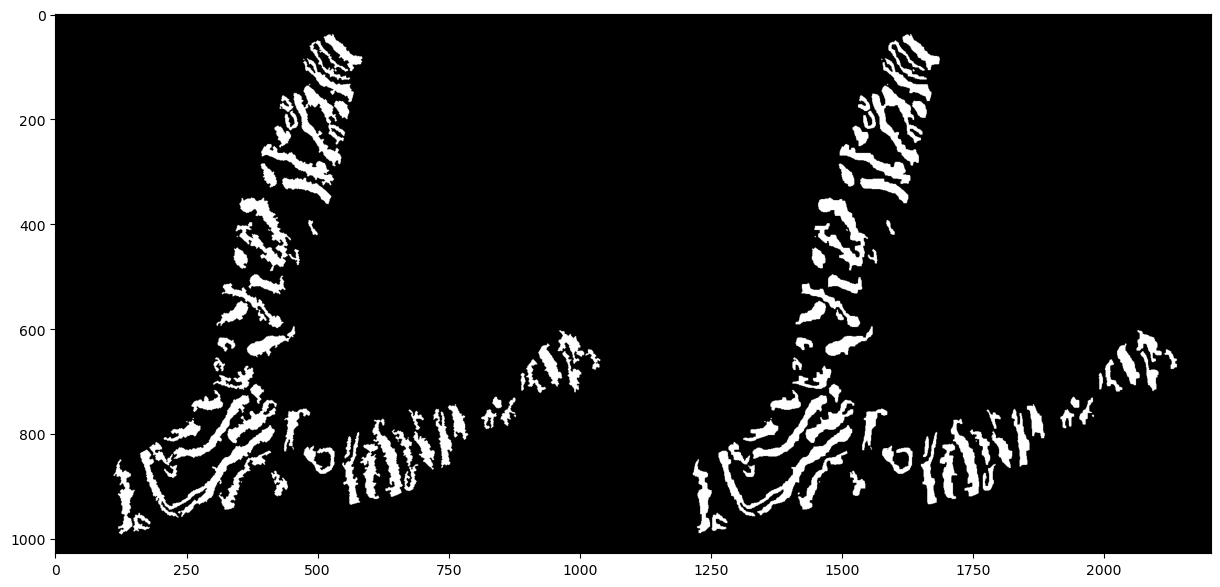

In [48]:
src = morph()
src = open(src,3)
k = 13
contours_in, _ = cv.findContours(src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
contours_out = [np.copy(ctr) for ctr in contours_in]

for ctr_in, ctr_out in zip(contours_in,contours_out):
    for i in range(k,len(ctr_out)):
        ctr_out[i-1,0,0] = np.median(ctr_in[i-k:i,0,0])
        ctr_out[i-1,0,1] = np.median(ctr_in[i-k:i,0,1])

dst = np.zeros_like(src)
dst = cv.drawContours(dst, contours_out, -1, 255, cv.FILLED)
plt.figure(figsize=(15,7))
plt.imshow(np.concatenate([src,dst],axis=1),cmap='gray')